In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns

In [2]:
data = pd.read_csv('Diabetes.csv')
data['Sex'] = data['Sex'].map({'female': 0, 'male': 1})
label_encoder = LabelEncoder()
data['Prediction'] = label_encoder.fit_transform(data['Prediction'])

In [3]:
data.head()

,S.No,Age,Sex,Fasting,Post Prandial,GTT 1/2 Hr,GTT 1 Hr,GTT 1-1/2 Hr,GTT 2 Hr,HbA1C,...,D.Bilirubin,Hemoglobin,TSH3,UricAcid,Homosystiene,hs-CRP,SOD,LPO,Apo B/Apo,Prediction
0,1,38,0,87,78.826087,146.000000,129.000000,112.000000,85.000000,5.8,...,0.10,10.9,1.31,3.000000,13.210000,0.651765,1.554,0,0,1
1,2,33,0,119,95.000000,89.000000,85.000000,5.500000,111.000000,6.9,...,1.50,2.7,15.85,4.158503,13.543922,0.651765,1.554,0,0,1
2,3,45,0,87,0.000000,105.000000,110.000000,80.000000,78.000000,5.7,...,0.10,14.1,2.74,3.000000,11.510000,0.000000,0.000,0,0,1
3,4,44,0,89,96.000000,179.688406,203.391304,196.184783,177.112676,6.2,...,0.20,9.0,2.71,3.200000,7.450000,0.651765,1.554,0,0,1
4,5,44,1,97,78.826087,215.000000,202.000000,127.000000,77.000000,5.4,...,0.17,14.9,5.52,3.800000,13.543922,0.651765,1.554,0,0,1


In [4]:
feature_columns = data.columns.difference(['ID No', 'Name', 'Prediction']).tolist()

In [5]:
accuracy_results = []
column_importance = {col: 0 for col in feature_columns}

In [6]:
def evaluate_model(selected_columns):
    X = data[selected_columns].values
    y = data['Prediction'].values
    
    y_encoded = (y == 'DM').astype(int)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    n_qubits = len(selected_columns)
    dev = qml.device('default.qubit', wires=n_qubits)

    params = np.random.normal(0, np.pi, size=n_qubits * 2)

    @qml.qnode(dev)
    def quantum_circuit(params, x):
        for i in range(n_qubits):
            qml.RY(x[i], wires=i)
        for i in range(len(params) // 2):
            qml.RY(params[2 * i], wires=i)
            if n_qubits > 1:
                qml.CNOT(wires=[i, (i + 1) % n_qubits])
            qml.RY(params[2 * i + 1], wires=(i + 1) % n_qubits)
        return qml.expval(qml.PauliZ(0))

    y_pred = np.array([quantum_circuit(params, X_train[i]) for i in range(len(X_train))])
    y_pred = (y_pred > 0).astype(int)
    
    accuracy = np.mean(y_pred == y_train)
    return accuracy

In [7]:
max_columns = len(feature_columns)
iterations = 5

In [8]:
sample = 1
for num_columns in range(1, max_columns + 1):
    for _ in range(iterations):
        if sample < 41:
            selected_columns = np.random.choice(feature_columns, size=num_columns, replace=False)
            
            accuracy = evaluate_model(selected_columns)
            
            if accuracy > 0.5 and len(selected_columns) > 2:
                
                print(f"Sample {sample}")
                print(f"\tNumber of columns: {len(selected_columns)}")
                print(f"\tAccuracy: {accuracy:.2%}")
                accuracy_results.append((selected_columns, accuracy))
                sample = sample + 1
                for col in selected_columns:
                    column_importance[col] += accuracy

Sample 1
	Number of columns: 3
	Accuracy: 62.50%
Sample 2
	Number of columns: 3
	Accuracy: 67.50%
Sample 3
	Number of columns: 3
	Accuracy: 99.17%
Sample 4
	Number of columns: 3
	Accuracy: 81.67%
Sample 5
	Number of columns: 4
	Accuracy: 77.50%
Sample 6
	Number of columns: 4
	Accuracy: 57.50%
Sample 7
	Number of columns: 5
	Accuracy: 58.33%
Sample 8
	Number of columns: 5
	Accuracy: 75.00%
Sample 9
	Number of columns: 6
	Accuracy: 55.83%
Sample 10
	Number of columns: 7
	Accuracy: 58.33%
Sample 11
	Number of columns: 7
	Accuracy: 60.00%
Sample 12
	Number of columns: 7
	Accuracy: 51.67%
Sample 13
	Number of columns: 7
	Accuracy: 55.00%
Sample 14
	Number of columns: 8
	Accuracy: 52.50%
Sample 15
	Number of columns: 9
	Accuracy: 52.50%
Sample 16
	Number of columns: 9
	Accuracy: 50.83%
Sample 17
	Number of columns: 9
	Accuracy: 55.83%
Sample 18
	Number of columns: 10
	Accuracy: 60.00%
Sample 19
	Number of columns: 10
	Accuracy: 60.83%
Sample 20
	Number of columns: 10
	Accuracy: 70.00%
Sample

In [12]:
accuracy_results = pd.DataFrame(accuracy_results, columns=["Features", "Accuracy"])
sorted_results = accuracy_results.sort_values(by=["Accuracy"], ascending=False)
sorted_results["No. Features"] = sorted_results["Features"].apply(len)

print(sorted_results)

                                             Features  Accuracy  No. Features
2                          [P, Apolipoprotein-B, SOD]  0.991667             3
3                         [Hemoglobin, UricAcid, BUN]  0.816667             3
4                     [Homosystiene, P, Insulin, Age]  0.775000             4
7                [TSH3, SGOT, SGPT, LPO, D.Bilirubin]  0.750000             5
23  [GTT 2 Hr, HbA1C, T.Cholesterol, Homosystiene,...  0.725000            12
22  [Homosystiene, Alb/Crea Ratio, TGL, Apolipopro...  0.708333            12
19  [Albumin, GTT 2 Hr, GTT 1/2 Hr, T.Cholesterol,...  0.700000            10
27  [Serum Creatinine, Microalbumin, Hemoglobin, G...  0.691667            13
1                           [Microalbumin, SGOT, LDL]  0.675000             3
21  [T.Protein, MGV, BUN, GTT 1 Hr, Microalbumin, ...  0.666667            11
38  [Age, Microalbumin, HDL, Apolipoprotein-A1, GT...  0.658333            18
36  [SGPT, MGV, Homosystiene, Apolipoprotein-A1, U...  0.658333 

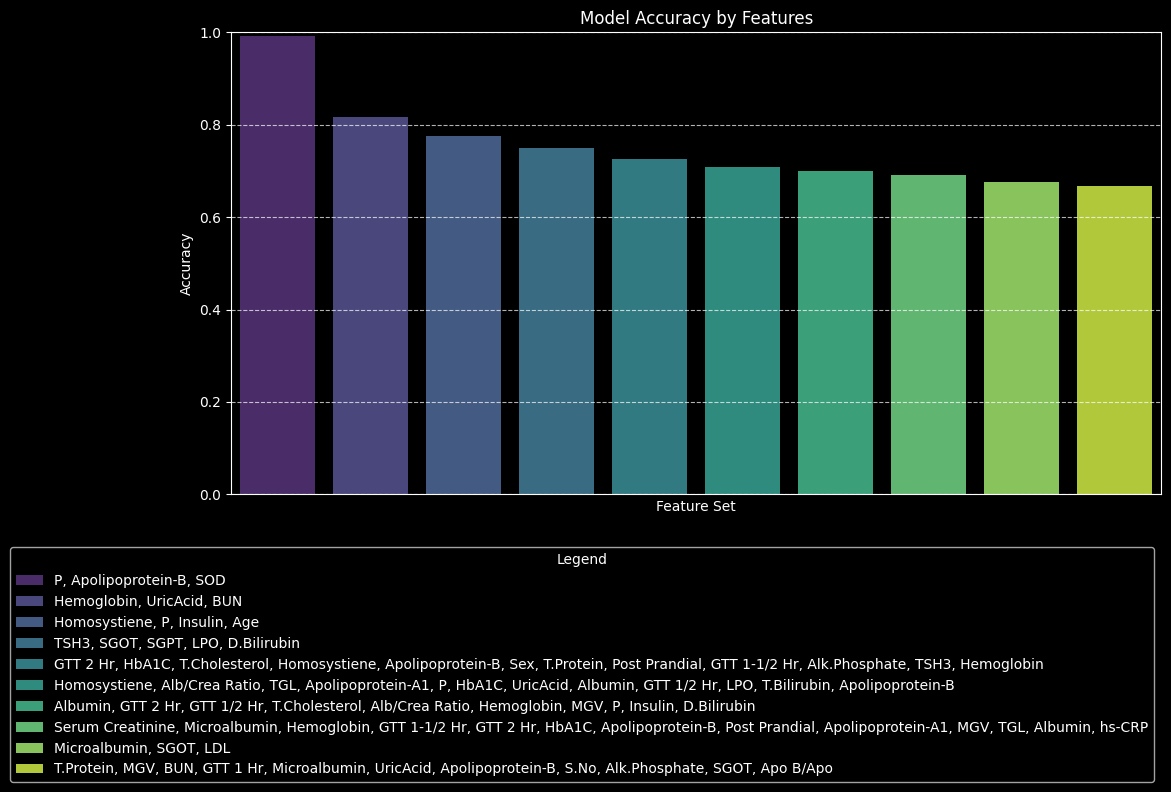

In [15]:
accuracy_results = pd.DataFrame(accuracy_results, columns=["Features", "Accuracy"])
sorted_results = accuracy_results.sort_values(by=["Accuracy"], ascending=False)
sorted_results["Features"] = sorted_results["Features"].apply(lambda x: ', '.join(x))[:10]

plt.figure(figsize=(12, 6))
sns.barplot(x="Features", y="Accuracy", data=sorted_results, palette="viridis", hue="Features")
plt.ylabel('Accuracy')
plt.xlabel('Feature Set')
plt.title('Model Accuracy by Features')
plt.ylim(0, 1)  
plt.xticks([])  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Legend', loc='upper right', bbox_to_anchor=(1, -0.1))
plt.show()